**In local terminal:**

```bash

conda create -n bmstu_cv_lab6 pip python=3.8
conda activate bmstu_cv_lab6

cd computer-vision\lesson6
mkdir lr\results

pip install -r lr/requirements_updated_trackeval.txt

mkdir trackeval
cd trackeval
git clone https://github.com/JonathonLuiten/TrackEval.git
curl -k -L -o data.zip https://omnomnom.vision.rwth-aachen.de/data/TrackEval/data.zip

python
>>> import zipfile
>>> with zipfile.ZipFile("data.zip", "r") as zip_ref:
...     zip_ref.extractall(".")
...
>>> exit()

del data.zip

cd TrackEval

python scripts/run_mot_challenge.py --BENCHMARK MOT20 --TRACKERS_TO_EVAL MPNTrack --TRACKERS_FOLDER ./data/trackers/mot_challenge --GT_FOLDER ./data/gt/mot_challenge


In [1]:
!wget https://motchallenge.net/data/MOT20.zip

--2025-12-15 22:55:57--  https://motchallenge.net/data/MOT20.zip
Resolving motchallenge.net (motchallenge.net)... 131.159.19.34, 2a09:80c0:18::1034
Connecting to motchallenge.net (motchallenge.net)|131.159.19.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5028926248 (4.7G) [application/zip]
Saving to: ‘MOT20.zip’

MOT20.zip           100%[===================>]   4.68G  18.5MB/s    in 4m 8s   

2025-12-15 23:00:06 (19.4 MB/s) - ‘MOT20.zip’ saved [5028926248/5028926248]



In [2]:
from IPython.display import clear_output
import os

In [3]:
!unzip MOT20.zip
os.remove('/kaggle/working/MOT20.zip')
clear_output()

In [4]:
!pip install ultralytics
!pip install -U numpy==1.26.4 scipy==1.11.4
clear_output()

In [5]:
from ultralytics import YOLO
import torch
import logging
from tqdm import tqdm

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [6]:
logging.getLogger("ultralytics").setLevel(logging.CRITICAL)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
def process_video(model, image_folder, output_file, conf_threshold=0.5, tracker='bytetrack'):

    results = model.track(
    source=image_folder,
    persist=True,
    conf=conf_threshold,
    tracker=f"{tracker}.yaml",
    verbose=False,
    device=device 
    )

    results = sorted(results, key = lambda x: x.path)
    
    with open(output_file, 'w') as f:
        for result in results:
            frame_id = int(result.path.split('/')[-1].split('.')[0])
            boxes = result.boxes
            for box in boxes:
                if box.id is None:
                    continue
                
                xyxy = box.xyxy[0].tolist()
                track_id = int(box.id.item())
                conf = box.conf.item()
                detectionClass = box.cls.item()
                
                if detectionClass != 0:
                    continue
                
                bb_left = xyxy[0]
                bb_top = xyxy[1]
                bb_width = xyxy[2] - xyxy[0]
                bb_height = xyxy[3] - xyxy[1]
                
                f.write(f'{frame_id},{track_id},{bb_left:.2f},{bb_top:.2f},{bb_width:.2f},{bb_height:.2f},{conf:.6f},-1,-1,-1\n')

In [8]:
mot_videos = os.listdir('/kaggle/working/MOT20/train')

for model_name in ['yolo11n', 'yolo11s', 'yolo11m']:
    for video in tqdm(mot_videos, desc=model_name):
        model = YOLO(f"{model_name}.pt")
        video_path = f'MOT20/train/{video}/img1/'
        output_file = f'results/by_model/{model_name}/data/{video}.txt'
        os.makedirs(os.path.dirname(output_file), exist_ok=True)
        process_video(model, video_path, output_file)

print("Tracking complete. Results saved in MOTChallenge format.")

yolo11n:   0%|          | 0/4 [00:00<?, ?it/s]

yolo11s:   0%|          | 0/4 [00:00<?, ?it/s]

yolo11m:   0%|          | 0/4 [00:00<?, ?it/s]

yolo11m: 100%|██████████| 4/4 [04:23<00:00, 65.84s/it] 

Tracking complete. Results saved in MOTChallenge format.


In [11]:
!zip -r results.zip /kaggle/working/results
clear_output()

**In local terminal:**

**(It's assumed that results.zip is downloaded from kaggle after by_model step and put to current TrackEval directory)**

```bash

python
>>> import zipfile
>>> with zipfile.ZipFile("results.zip", "r") as zip_ref:
...     zip_ref.extractall("data/trackers/mot_challenge/MOT20-train")
...
>>> exit()

del results.zip

python scripts/run_mot_challenge.py --BENCHMARK MOT20 --TRACKERS_TO_EVAL kaggle/working/results/by_model/yolo11n --TRACKERS_FOLDER ./data/trackers/mot_challenge --GT_FOLDER ./data/gt/mot_challenge
python scripts/run_mot_challenge.py --BENCHMARK MOT20 --TRACKERS_TO_EVAL kaggle/working/results/by_model/yolo11s --TRACKERS_FOLDER ./data/trackers/mot_challenge --GT_FOLDER ./data/gt/mot_challenge
python scripts/run_mot_challenge.py --BENCHMARK MOT20 --TRACKERS_TO_EVAL kaggle/working/results/by_model/yolo11m --TRACKERS_FOLDER ./data/trackers/mot_challenge --GT_FOLDER ./data/gt/mot_challenge

move data\trackers\mot_challenge\MOT20-train\kaggle\working\results\by_model ..\..\lr\results



The best result was shown by the model with medium size. To choose the best tracking algorythm we will use this model.

In [15]:
!mkdir -p /kaggle/working/results/by_tracker
!cp -r /kaggle/working/results/by_model/yolo11m /kaggle/working/results/by_tracker
!mv /kaggle/working/results/by_tracker/yolo11m /kaggle/working/results/by_tracker/bytetrack

In [22]:
mot_videos = os.listdir('/kaggle/working/MOT20/train')
model_name = 'yolo11m'
tracker = 'botsort'

for video in tqdm(mot_videos, desc=model_name):
    model = YOLO(f"{model_name}.pt")
    video_path = f'MOT20/train/{video}/img1/'
    output_file = f'results/by_tracker/{tracker}/data/{video}.txt'
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    process_video(model, video_path, output_file, tracker=tracker)

print("Tracking complete. Results saved in MOTChallenge format.")

yolo11m: 100%|██████████| 4/4 [00:00<00:00, 12.40it/s]

Tracking complete. Results saved in MOTChallenge format.


In [20]:
!zip -r results.zip /kaggle/working/results
clear_output()

**In local terminal:**

**(It's assumed that results.zip is downloaded from kaggle after by_model step and put to current TrackEval directory)**

```bash

python
>>> import zipfile
>>> with zipfile.ZipFile("results.zip", "r") as zip_ref:
...     zip_ref.extractall("data/trackers/mot_challenge/MOT20-train")
...
>>> exit()

del results.zip

python scripts/run_mot_challenge.py --BENCHMARK MOT20 --TRACKERS_TO_EVAL kaggle/working/results/by_tracker/bytetrack --TRACKERS_FOLDER ./data/trackers/mot_challenge --GT_FOLDER ./data/gt/mot_challenge
python scripts/run_mot_challenge.py --BENCHMARK MOT20 --TRACKERS_TO_EVAL kaggle/working/results/by_tracker/botsort --TRACKERS_FOLDER ./data/trackers/mot_challenge --GT_FOLDER ./data/gt/mot_challenge

move data\trackers\mot_challenge\MOT20-train\kaggle\working\results\by_tracker ..\..\lr\results

The best result was shown by the model with medium size and botsort algorythm. Now we will choose the optimal confidence threshold.

In [21]:
!mkdir -p /kaggle/working/results/by_conf
!cp -r /kaggle/working/results/by_tracker/botsort /kaggle/working/results/by_conf
!mv /kaggle/working/results/by_conf/botsort /kaggle/working/results/by_conf/0_5

In [46]:
mot_videos = os.listdir('/kaggle/working/MOT20/train')
model_name = 'yolo11m'
tracker = 'botsort'

for conf in [0.25, 0.3, 0.35, 0.4, 0.45]:
    for video in tqdm(mot_videos, desc=str(conf)):
        model = YOLO(f"{model_name}.pt")
        video_path = f'MOT20/train/{video}/img1/'
        output_file = f'results/by_conf/{str(conf).replace(".","_")}/data/{video}.txt'
        os.makedirs(os.path.dirname(output_file), exist_ok=True)
        process_video(model, video_path, output_file, tracker=tracker, conf_threshold=conf)

print("Tracking complete. Results saved in MOTChallenge format.")


0.25: 100%|██████████| 4/4 [09:00<00:00, 135.04s/it]

0.3: 100%|██████████| 4/4 [08:45<00:00, 131.43s/it]

0.35: 100%|██████████| 4/4 [08:39<00:00, 129.96s/it]

0.4: 100%|██████████| 4/4 [08:37<00:00, 129.26s/it]

0.45: 100%|██████████| 4/4 [08:50<00:00, 132.53s/it]

Tracking complete. Results saved in MOTChallenge format.


In [47]:
!zip -r results.zip /kaggle/working/results
clear_output()

**In local terminal:**

**(It's assumed that results.zip is downloaded from kaggle after by_model step and put to current TrackEval directory)**

```bash

python
>>> import zipfile
>>> with zipfile.ZipFile("results.zip", "r") as zip_ref:
...     zip_ref.extractall("data/trackers/mot_challenge/MOT20-train")
...
>>> exit()

del results.zip

python scripts/run_mot_challenge.py --BENCHMARK MOT20 --TRACKERS_TO_EVAL kaggle/working/results/by_conf/0_25 --TRACKERS_FOLDER ./data/trackers/mot_challenge --GT_FOLDER ./data/gt/mot_challenge
python scripts/run_mot_challenge.py --BENCHMARK MOT20 --TRACKERS_TO_EVAL kaggle/working/results/by_conf/0_3 --TRACKERS_FOLDER ./data/trackers/mot_challenge --GT_FOLDER ./data/gt/mot_challenge
python scripts/run_mot_challenge.py --BENCHMARK MOT20 --TRACKERS_TO_EVAL kaggle/working/results/by_conf/0_35 --TRACKERS_FOLDER ./data/trackers/mot_challenge --GT_FOLDER ./data/gt/mot_challenge
python scripts/run_mot_challenge.py --BENCHMARK MOT20 --TRACKERS_TO_EVAL kaggle/working/results/by_conf/0_4 --TRACKERS_FOLDER ./data/trackers/mot_challenge --GT_FOLDER ./data/gt/mot_challenge
python scripts/run_mot_challenge.py --BENCHMARK MOT20 --TRACKERS_TO_EVAL kaggle/working/results/by_conf/0_45 --TRACKERS_FOLDER ./data/trackers/mot_challenge --GT_FOLDER ./data/gt/mot_challenge
python scripts/run_mot_challenge.py --BENCHMARK MOT20 --TRACKERS_TO_EVAL kaggle/working/results/by_conf/0_5 --TRACKERS_FOLDER ./data/trackers/mot_challenge --GT_FOLDER ./data/gt/mot_challenge

move data\trackers\mot_challenge\MOT20-train\kaggle\working\results\by_conf ..\..\lr\results

With the confidence threshold being increased, MOTA increases, but HOTA decreases.

In [48]:
!rm -rf /kaggle/working/MOT20
!rm /kaggle/working/results.zip
!rm /kaggle/working/yolo11n.pt
!rm /kaggle/working/yolo11s.pt
!rm /kaggle/working/yolo11m.pt

**In local terminal:**

```bash

cd..
cd..

rmdir /S /Q trackeval

### Now with this notebook being downloaded from kaggle and put to the project directory

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def load_image(filepath):
    image = cv2.cvtColor(cv2.imread(filepath), cv2.COLOR_BGR2RGB)
    return image[57:image.shape[0]-53, 80:image.shape[1]-64]

def plot_results(images, labels=None):

    n = len(images)
    cols = min(3, n)
    rows = (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*5))
    axes = axes.flatten()

    for i, img in enumerate(images):
        axes[i].imshow(img)
        axes[i].axis('on')

        x_ticks = np.linspace(0, img.shape[1]-1, 6)
        y_ticks = np.linspace(0, img.shape[0]-1, 6)
        axes[i].set_xticks(x_ticks)
        axes[i].set_yticks(y_ticks)
        axes[i].set_xticklabels([f"{v:.1f}" for v in np.linspace(0,1,6)])
        axes[i].set_yticklabels([f"{v:.1f}" for v in np.linspace(0,1,6)])

        if labels is not None:
            axes[i].set_title(labels[i], fontsize=12)

    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

**By models:**

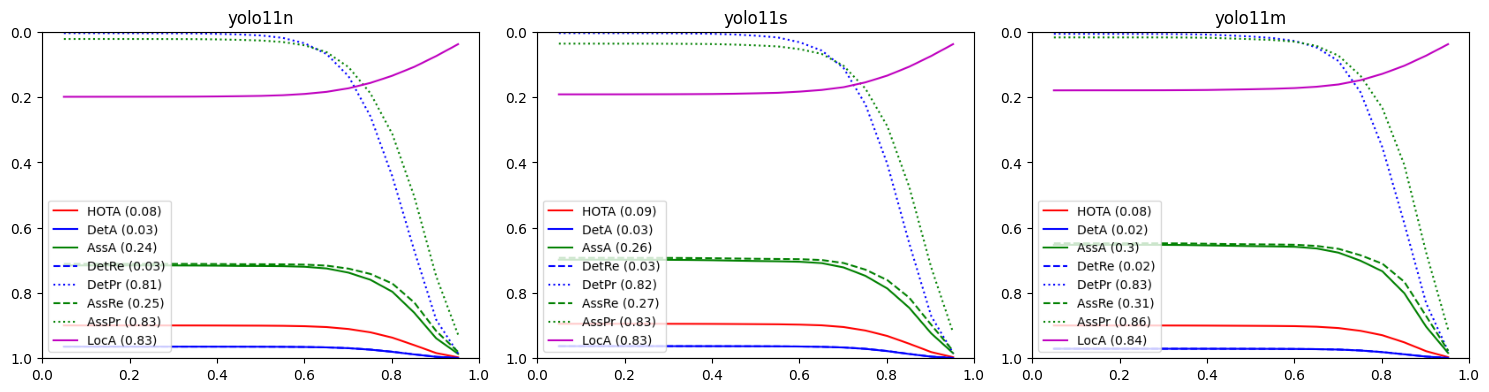

In [3]:
models = ['yolo11n', 'yolo11s', 'yolo11m']
paths = [f'results/by_model/{model}/pedestrian_plot.png' for model in models]
images = [load_image(path) for path in paths]
plot_results(images, labels=models)

**By tracker:**

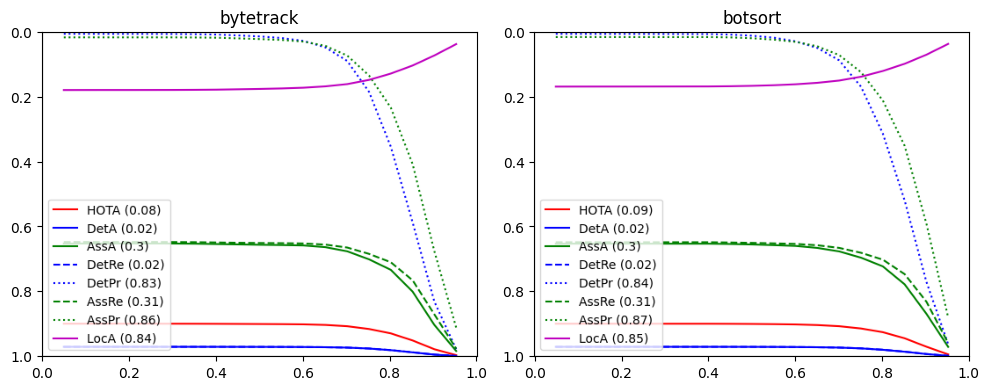

In [4]:
trackers = ['bytetrack', 'botsort']
paths = [f'results/by_tracker/{tracker}/pedestrian_plot.png' for tracker in trackers]
images = [load_image(path) for path in paths]
plot_results(images, labels=trackers)

**By confidence threshold:**

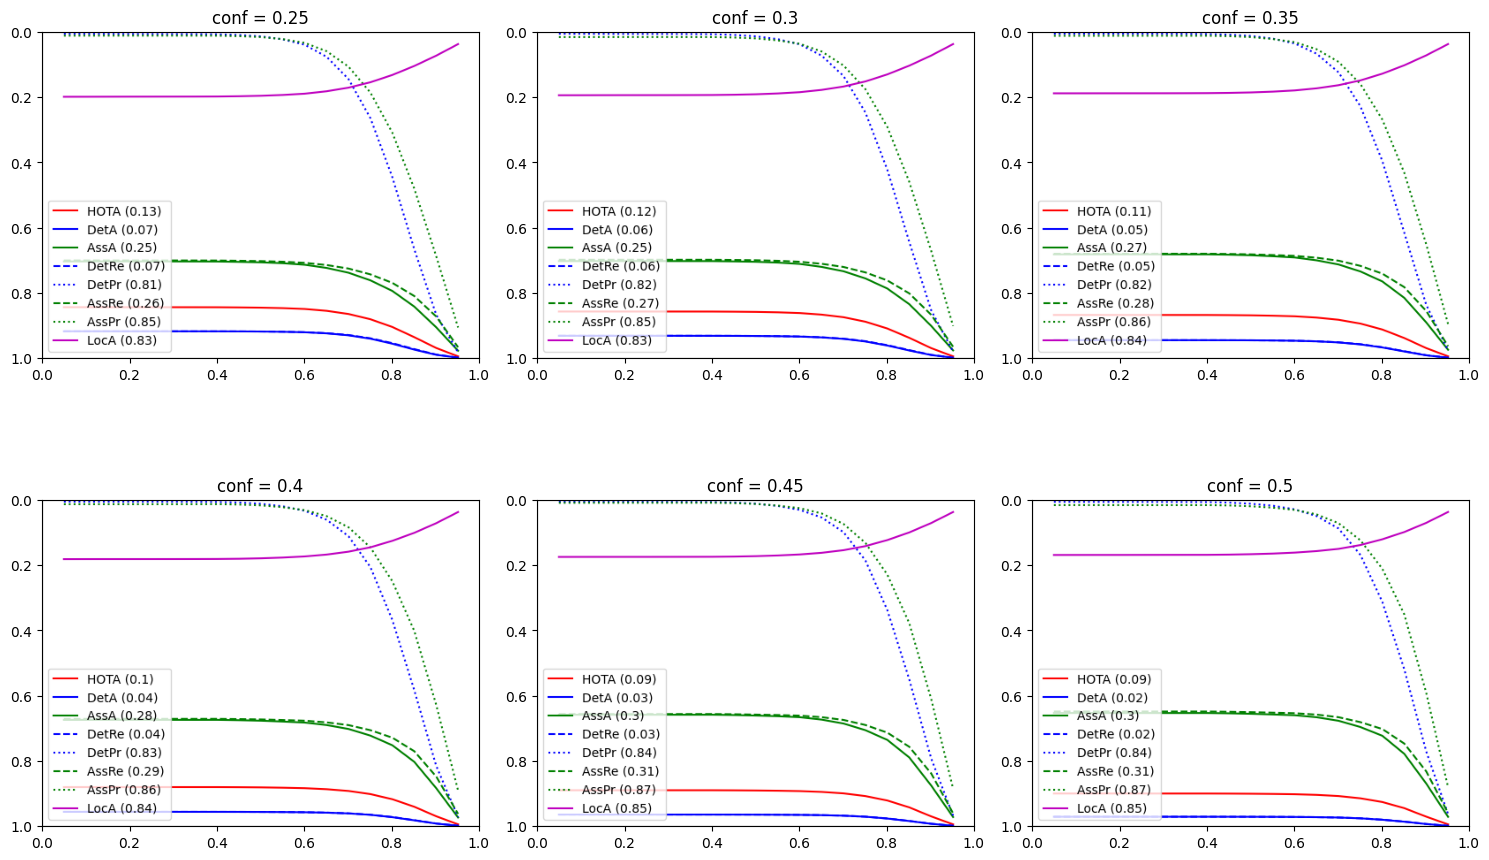

In [5]:
confs = ['0_25', '0_3', '0_35', '0_4', '0_45', '0_5']
paths = [f'results/by_conf/{conf}/pedestrian_plot.png' for conf in confs]
images = [load_image(path) for path in paths]
plot_results(images, labels=['conf = ' + conf.replace('_', '.') for conf in confs])